# Results

This Jupyter notebook is designed to demonstrate the loading of three distinct trained ensemble models, perform predictions on new data, and evaluate these predictions using several metrics: accuracy, recall, precision, and F1 score. The process encompasses obtaining predictions from individual learners within each ensemble and aggregating these predictions to form the final ensemble predictions. The evaluation metrics provide a comprehensive understanding of the ensemble models' performance on the given dataset.


## Import Required Libraries

First, we import all necessary libraries and modules. This includes standard data processing and machine learning libraries such as NumPy and joblib for model loading, and specific functions from scikit-learn for ensemble methods and metrics. We also suppress warnings to keep the notebook clean and more readable.

In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import joblib
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import gc
from sklearn.metrics import (
    accuracy_score, 
    recall_score, 
    precision_score, 
    f1_score
)
import matplotlib.pyplot as plt


## Load Dataset

In [3]:
def read_csv_file(filename: str) -> pd.DataFrame:
    """
    Read the given file. Raises an error and quits script
    if the file does not exist.

    Args:
        filename (str): A string filename. Must be a csv file.

    Returns:
        pd.DataFrame: A pandas data frame whose data can be
            manipulated
    """
    try:
        return pd.read_csv(
            filename, 
            lineterminator='\n',
            usecols=(range(2)),
        )
    except FileNotFoundError:
        print("ERROR: File not found")
        exit(1)

csv = read_csv_file('datasets/combined-hate-tagalog-taglish.csv')

csv

,text,label
0,Binay: Patuloy ang kahirapan dahil sa maling p...,0
1,SA GOBYERNONG TAPAT WELCOME SA BAGUO ANG LAHAT...,0
2,wait so ur telling me Let Leni Lead mo pero NY...,1
3,[USERNAME]wish this is just a nightmare that ...,0
4,doc willie ong and isko sabunutan po,0
...,...,...
28455,"Bisaya, Probinsyano/a, mostly Bisaya = katulong",1
28456,Amnesia. In my whole life wala pa ako nakasala...,1
28457,Kontrabida na ilang beses na tinalo at obvious...,1
28458,Yung antagonist laging kailangang sobrang sama...,1


### Get Test Data

In [4]:
def get_train_test_split(data_frame: pd.DataFrame):
    """
    Args:
        data_frame (pd.DataFrame): The data frame obtained from
            reading a csv file
    Returns:
        X_train
        X_test
        y_train
        y_test
    """
    text = data_frame['text']
    labels = data_frame['label']

    labels = np.array(labels)

    X_train, X_test, y_train, y_test = train_test_split(
        text, 
        labels, 
        test_size=0.2,  # 80/20 train/test split
        random_state=42,
    )

    return X_train, X_test, y_train, y_test

_, X_test, _, y_test = get_train_test_split(csv)

In [7]:
pd.DataFrame(X_test)

,text
8374,Grabe andami ads ni Only Binay kawawa nmn taxe...
12922,LOOK Presidential candidate Ka Leody de Guzman...
18002,[USERNAME] Not like that Wharton-bred Mar Roxa...
26027,Uso mag move on [USERNAME] Roxas Quit Now POE2016
16004,[USERNAME] Mar Roxas and Binay. Both turned do...
...,...
5418,Wala naman kasing maibibintang sayo kung walan...
28442,Maaga plng ba? Ang iingay ng mga tumatakbo sa ...
1977,[USERNAME] Oct Leody de Guzman should foster ...
27198,This is the most puzzling thing! No. 1 sa blac...


In [8]:
pd.DataFrame(y_test)

,0
0,1
1,0
2,1
3,0
4,0
...,...
5687,1
5688,1
5689,0
5690,0


## Results Functions

In [6]:
def get_ensemble_results(X_test: list, y_test: list, ensemble):
    """
    Predict with the trained ensemble using the csv data.
    Gives quantifiable results.

    Args:
        X_test: From the csv after train-test split
        y_test: From the csv after train-test split
        ensemble (VotingClassifier | StackingClassifier):
            A trained hard voting, soft voting, or stacking 
            ensemble from scikit-learn

    Returns:
        accuracy (float)
        recall (float)
        precision (float)
        f1 (float)
    """
    with torch.inference_mode():
        y_pred = ensemble.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        return accuracy, recall, precision, f1

In [7]:
def get_learner_results(X_test: list, y_test: list, ensemble):
    with torch.inference_mode():
        predictions = []
        for estimator in ensemble.estimators_:
            y_pred = estimator.predict(X_test)
            estimator_results = []
            estimator_results.append(accuracy_score(y_test, y_pred))
            estimator_results.append(recall_score(y_test, y_pred))
            estimator_results.append(precision_score(y_test, y_pred))
            estimator_results.append(f1_score(y_test, y_pred))
            predictions.append(estimator_results)
        return predictions

## Results Display Functions

In [9]:
def plot_grouped_bar_graph(data, labels, title="Performance Metrics"):
    data = np.array(data).T
    groups = len(data)
    num_of_bars = len(data[0])
    bar_width = 0.2
    bar_locations = np.arange(num_of_bars)
    bar_names = ('Accuracy', 'Precision', 'Recall', 'F1-score')

    # Create subplot
    fig, ax = plt.subplots()
    
    for i in range(groups):
        bars = ax.bar(bar_locations + i * bar_width, data[i], width=bar_width, label=bar_names[i])
        ax.bar_label(bars, fmt='%.2f', fontsize='small')

    ax.set_xlabel('Learners')
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(bar_locations + 0.3, labels)
    ax.set_xticklabels(labels)
    ax.legend()
    
    plt.show()

learner_labels = ['Bernoulli Naive Bayes', 'LSTM', 'mBERT']

## Load Ensemble Models

Here, we load the pre-trained ensemble models from their respective files. These models have been saved previously using the joblib library, which allows for easy storage and loading of Python objects. Ensure that the paths to the model files ('ensemble1.pkl', 'ensemble2.pkl', 'ensemble3.pkl') are correct and accessible.

### Hard Voting Ensemble

In [10]:
hard_ensemble = joblib.load('ensemble-hard.pkl')
hard_ensemble

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VotingClassifier(estimators=[('nb',
                              Pipeline(steps=[('tfidf',
                                               TfidfVectorizer(stop_words=['akin',
                                                                           'aking',
                                                                           'ako',
                                                                           'alin',
                                                                           'am',
                                                                           'amin',
                                                                           'aming',
                                                                           'ang',
                                                                           'ano',
                                                                           'anumang',
                                                                           'apat',
                                                                           'at',
                                                                           'atin',
                                                                           'ating',
                                                                           'ay',
                                                                           'bababa',
                                                                           'bago',
                                                                           'bakit',
                                                                           'bawat',
                                                                           'bilang',
                                                                           'dahil',
                                                                           'dalawa',
                                                                           'dapat',
                                                                           'din',
                                                                           'dito',
                                                                           'doon',
                                                                           'gagawin',
                                                                           'gayunman',
                                                                           'ginagawa',
                                                                           'ginawa', ...])),
                                              ('bayes', BernoulliNB())]))...
                                               <class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class 'src.LSTM.LstmModel'>,
  module__hidden_size=400,
))])),
                             ('bert',
                              Pipeline(steps=[('tokenizer',
                                               HuggingfacePretrainedTokenizer(max_length=255,
                                                                              tokenizer='bert-base-multilingual-cased')),
                                              ('bert',
                                               <class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class 'src.BERT.BertModel'>,
))]))])

In [11]:
hard_ensemble_results = get_ensemble_results(X_test, y_test, hard_ensemble)

In [12]:
hard_ensemble_learners = get_learner_results(X_test, y_test, hard_ensemble)

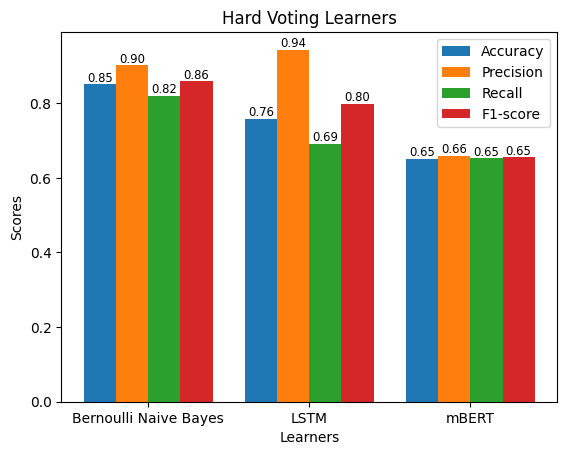

In [13]:
plot_grouped_bar_graph(hard_ensemble_learners, learner_labels, "Hard Voting Learners")

In [14]:
del hard_ensemble
gc.collect()

3923

### Soft Voting Ensemble

In [11]:
soft_ensemble = joblib.load('ensemble-soft.pkl')
soft_ensemble

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VotingClassifier(estimators=[('nb',
                              Pipeline(steps=[('tfidf',
                                               TfidfVectorizer(stop_words=['akin',
                                                                           'aking',
                                                                           'ako',
                                                                           'alin',
                                                                           'am',
                                                                           'amin',
                                                                           'aming',
                                                                           'ang',
                                                                           'ano',
                                                                           'anumang',
                                                                           'apat',
                                                                           'at',
                                                                           'atin',
                                                                           'ating',
                                                                           'ay',
                                                                           'bababa',
                                                                           'bago',
                                                                           'bakit',
                                                                           'bawat',
                                                                           'bilang',
                                                                           'dahil',
                                                                           'dalawa',
                                                                           'dapat',
                                                                           'din',
                                                                           'dito',
                                                                           'doon',
                                                                           'gagawin',
                                                                           'gayunman',
                                                                           'ginagawa',
                                                                           'ginawa', ...])),
                                              ('bayes', BernoulliNB())]))...
                                               <class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class 'src.LSTM.LstmModel'>,
  module__hidden_size=400,
))])),
                             ('bert',
                              Pipeline(steps=[('tokenizer',
                                               HuggingfacePretrainedTokenizer(max_length=255,
                                                                              tokenizer='bert-base-multilingual-cased')),
                                              ('bert',
                                               <class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class 'src.BERT.BertModel'>,
))]))],
                 voting='soft')

In [12]:
soft_ensemble_results = get_ensemble_results(X_test, y_test, soft_ensemble)

In [13]:
soft_ensemble_learners = get_learner_results(X_test, y_test, soft_ensemble)

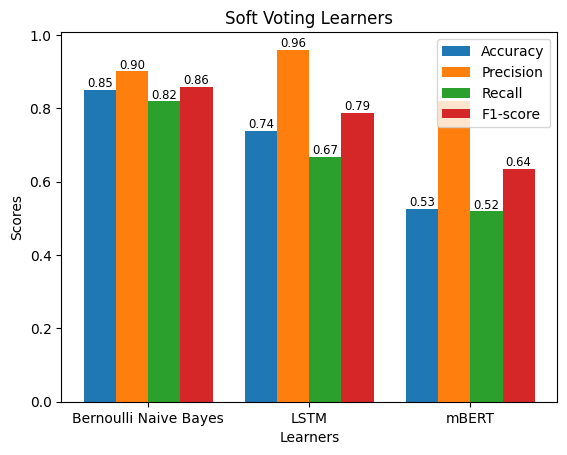

In [14]:
plot_grouped_bar_graph(soft_ensemble_learners, learner_labels, "Soft Voting Learners")

In [15]:
del soft_ensemble

### Stacking Ensemble

In [10]:
stacking_ensemble = joblib.load('ensemble-stacking.pkl')
stacking_ensemble

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


StackingClassifier(cv=3,
                   estimators=[('nb',
                                Pipeline(steps=[('tfidf',
                                                 TfidfVectorizer(stop_words=['akin',
                                                                             'aking',
                                                                             'ako',
                                                                             'alin',
                                                                             'am',
                                                                             'amin',
                                                                             'aming',
                                                                             'ang',
                                                                             'ano',
                                                                             'anumang',
                                                                             'apat',
                                                                             'at',
                                                                             'atin',
                                                                             'ating',
                                                                             'ay',
                                                                             'bababa',
                                                                             'bago',
                                                                             'bakit',
                                                                             'bawat',
                                                                             'bilang',
                                                                             'dahil',
                                                                             'dalawa',
                                                                             'dapat',
                                                                             'din',
                                                                             'dito',
                                                                             'doon',
                                                                             'gagawin',
                                                                             'gayunman',
                                                                             'ginagawa',
                                                                             'ginawa', ...])),
                                                ('bayes', BernoulliN...
                                                 <class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class 'src.LSTM.LstmModel'>,
  module__hidden_size=400,
))])),
                               ('bert',
                                Pipeline(steps=[('tokenizer',
                                                 HuggingfacePretrainedTokenizer(max_length=255,
                                                                                tokenizer='bert-base-multilingual-cased')),
                                                ('bert',
                                                 <class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class 'src.BERT.BertModel'>,
))]))],
                   final_estimator=LogisticRegression())

In [11]:
stacking_ensemble_results = get_ensemble_results(X_test, y_test, stacking_ensemble)

In [12]:
stacking_ensemble_learners = get_learner_results(X_test, y_test, stacking_ensemble)

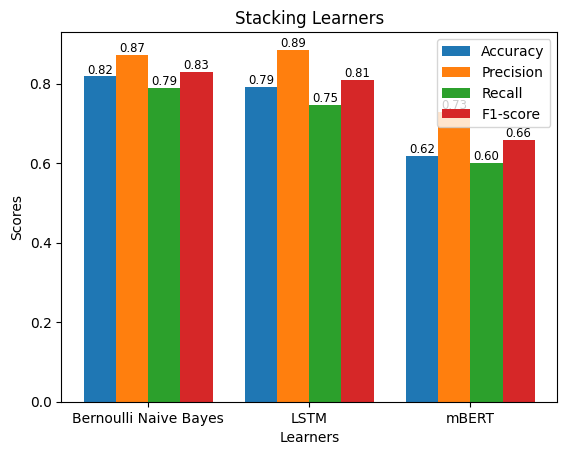

In [13]:
plot_grouped_bar_graph(stacking_ensemble_learners, learner_labels, "Stacking Learners")

## Ensemble Results

In [ ]:
ensemble_results = [hard_ensemble_results, soft_ensemble_results, stacking_ensemble_results]
ensemble_labels = ['Hard Voting', 'Soft Voting', 'Stacking']

In [ ]:
plot_grouped_bar_graph(ensemble_results, ensemble_labels, "Ensemble Results")